In [1]:
import logging
# ===================================================================
#                      1. SETUP AND IMPORTS
# ===================================================================
# --- Standard library imports ---
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
# --- Third-party imports ---
import seaborn as sns

# This notebook assumes the VDB/wavelet libraries are installed.
# The following lines are from the user's script and may need to be adjusted
# to your specific environment.
try:
    os.add_dll_directory("C:/Users/zphrfx/Desktop/hdk/VQVDB/.venv/Lib/site-packages")
    os.add_dll_directory("C:/vcpkg/installed/x64-windows/bin")
    import openvdb as vdb
    import pywt
    import tensorly as tl
    from tensorly.decomposition import parafac
    from sklearn.decomposition import IncrementalPCA

    print("Successfully imported core libraries (OpenVDB, PyWavelets, Tensorly).")
except ImportError as e:
    logging.error("Failed to import core libraries. Please ensure they are installed in your environment.")
    raise e

# --- Notebook-specific setup ---
sns.set_theme(style="whitegrid")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Create a temporary directory for our experiment files
DATA_DIR = pathlib.Path("vdb_compression_analysis")
if DATA_DIR.exists():
    shutil.rmtree(DATA_DIR)
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nJupyter Notebook setup complete. Files will be stored in: ./{DATA_DIR}")

Successfully imported core libraries (OpenVDB, PyWavelets, Tensorly).

Jupyter Notebook setup complete. Files will be stored in: ./vdb_compression_analysis


In [2]:
from wavelet_compression_control import *

2025-08-01 21:24:39,664 - INFO - Inferring grid size from origin files...
2025-08-01 21:24:39,675 - INFO - Inferred grid size to be at least (232, 232, 232)
2025-08-01 21:24:39,676 - INFO - Reconstructing 30 ground truth frames...
2025-08-01 21:24:39,711 - INFO -   ... reconstructed frame 10/30
2025-08-01 21:24:39,833 - INFO -   ... reconstructed frame 20/30
2025-08-01 21:24:39,992 - INFO -   ... reconstructed frame 30/30
2025-08-01 21:24:40,029 - INFO - Successfully loaded and reconstructed 30 frames of size 232x232x232.


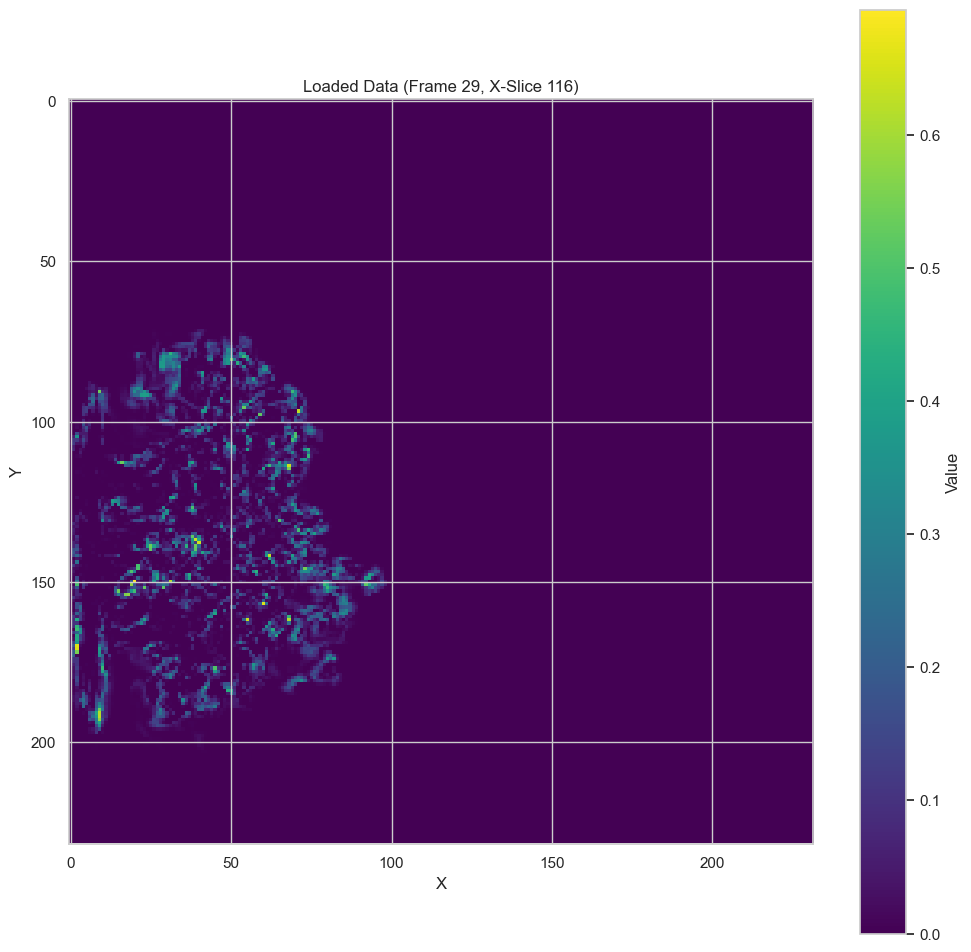

In [14]:
# ===================================================================
#                3. LOAD CUSTOM NPY SEQUENCE
# ===================================================================
# This section loads your pre-existing .npy sequence and reconstructs
# the full 3D frames to serve as the "ground truth" for our analysis.

# -----------------  USER CONFIGURATION  -----------------
USER_DATA_PATH = pathlib.Path("C:/Users/zphrfx/Desktop/hdk/VQVDB/data/npy/subs_ground_explosion/npy")
ORIGIN_PATH = USER_DATA_PATH / "origin"

# These parameters must match your data and desired compression settings
BLOCK_SIZE = 8
WAVELET_LEVELS = 2
WAVELET_NAME = 'db2'


# --------------------------------------------------------

def reconstruct_ground_truth(npy_paths, origin_paths, block_size):
    """
    Reconstructs full 3D numpy frames from a sequence of sparse blocks.
    Also infers the total grid size from the block origins.
    """
    if not npy_paths:
        raise FileNotFoundError("No .npy files found. Check USER_DATA_PATH.")

    logging.info("Inferring grid size from origin files...")
    max_coords = np.array([0, 0, 0])
    for opath in origin_paths:
        origins = np.load(opath)
        if origins.size > 0:
            max_coords = np.maximum(max_coords, np.max(origins, axis=0))

    # Calculate grid size as the max origin coordinate + block size
    # We'll make it a cube for simplicity, taking the largest dimension.
    grid_dim = int(np.max(max_coords) + block_size)
    grid_size = (grid_dim, grid_dim, grid_dim)
    logging.info(f"Inferred grid size to be at least {grid_size}")

    logging.info(f"Reconstructing {len(npy_paths)} ground truth frames...")
    all_frames = []
    for i, (npath, opath) in enumerate(zip(npy_paths, origin_paths)):
        blocks = np.load(npath)
        origins = np.load(opath)

        # Create an empty canvas for the full frame
        full_frame = np.zeros(grid_size, dtype=np.float32)

        if blocks.size > 0:
            for block, origin in zip(blocks, origins):
                ox, oy, oz = origin
                full_frame[ox:ox + block_size, oy:oy + block_size, oz:oz + block_size] = block

        all_frames.append(full_frame)
        if (i + 1) % 10 == 0:
            logging.info(f"  ... reconstructed frame {i + 1}/{len(npy_paths)}")

    return all_frames, grid_dim


# --- Find and load data ---
# Use glob to find files matching a pattern, and sort them to ensure order
npy_paths = sorted([str(p) for p in USER_DATA_PATH.glob("untitled.filecache1.*.npy")])
origin_paths = sorted([str(p) for p in ORIGIN_PATH.glob("untitled.filecache1.*._origins.npy")])

assert len(npy_paths) == len(origin_paths), "Mismatch between number of block files and origin files."
assert len(npy_paths) > 0, f"No data found at the specified path: {USER_DATA_PATH}"

N_FRAMES = len(npy_paths)

# Reconstruct the original full 3D frames from the sparse .npy files
original_frames, GRID_SIZE = reconstruct_ground_truth(npy_paths, origin_paths, BLOCK_SIZE)

logging.info(f"Successfully loaded and reconstructed {N_FRAMES} frames of size {GRID_SIZE}x{GRID_SIZE}x{GRID_SIZE}.")

# --- Visualize a sample of the loaded data to confirm it's correct ---
sample_frame_idx = N_FRAMES - 1
sample_slice_idx = GRID_SIZE // 2  # Middle slice in the Z dimension

plt.figure(figsize=(12, 12))
plt.imshow(original_frames[sample_frame_idx][sample_slice_idx, :, :], cmap='viridis')
plt.title(f"Loaded Data (Frame {sample_frame_idx}, X-Slice {sample_slice_idx})")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Value")
plt.show()

In [15]:
import time


# ===================================================================
#                4. ANALYSIS HELPER FUNCTIONS
# ===================================================================
# These functions will help us run experiments and analyze the results.
# They are generic and work with the 'original_frames' list, regardless
# of how it was generated.

def decompress_to_numpy(in_path: str, grid_size: int, block_size: int) -> list[np.ndarray]:
    """
    Decompresses a .vdbr file and reconstructs the full 3D NumPy arrays for each frame.
    This is a custom version of the decompress method for easier analysis in the notebook.
    """
    with open(in_path, "rb") as fp:
        magic, _, _, blk, lvl, rank, n_frames = HEADER_STRUCT.unpack(fp.read(HEADER_STRUCT.size))
        if magic != MAGIC: raise ValueError("Invalid VDBR file")
        scale, coeff_len, n_blocks, json_bytes = META_STRUCT.unpack(fp.read(META_STRUCT.size))
        meta = json.loads(fp.read(json_bytes))
        coords = np.frombuffer(fp.read(n_blocks * 3 * 4), dtype=np.int32).reshape(n_blocks, 3)
        weights = np.frombuffer(fp.read(rank * 4), dtype=np.float32)
        A = np.frombuffer(fp.read(n_frames * rank * 4), dtype=np.float32).reshape(n_frames, rank)
        B = np.frombuffer(fp.read(n_blocks * rank * 4), dtype=np.float32).reshape(n_blocks, rank)
        C = np.frombuffer(fp.read(coeff_len * rank * 4), dtype=np.float32).reshape(coeff_len, rank)

    q_matrix = cp_decompress(weights, [A, B, C])
    coeff_tensor = dequantise(q_matrix, scale)

    wavelet = meta.get("wavelet", "haar")
    _, coeff_slices, _ = wavedec3(np.zeros((blk,) * 3), wavelet, lvl)

    reconstructed_frames = []
    for fi in range(n_frames):
        full_frame = np.full((grid_size, grid_size, grid_size), meta["background"], dtype=np.float32)
        for bi in range(n_blocks):
            arr = coeff_tensor[fi, bi].reshape(blk, blk, blk)
            dense_block = waverec3(arr, coeff_slices, wavelet)
            ox, oy, oz = coords[bi]
            full_frame[ox:ox + blk, oy:oy + blk, oz:oz + blk] = dense_block
        reconstructed_frames.append(full_frame)

    return reconstructed_frames


def calculate_metrics(original, reconstructed, file_size_bytes):
    """Calculates RMSE, PSNR, and Compression Ratio."""
    original = np.stack(original)
    reconstructed = np.stack(reconstructed)

    raw_uncompressed_size = original.nbytes
    compression_ratio = raw_uncompressed_size / file_size_bytes if file_size_bytes > 0 else float('inf')

    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return {'rmse': 0, 'psnr': float('inf'), 'ratio': compression_ratio}

    rmse = np.sqrt(mse)
    max_pixel_value = np.max(original)
    if max_pixel_value == 0: max_pixel_value = 1.0
    psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

    return {'rmse': rmse, 'psnr': psnr, 'ratio': compression_ratio}


def run_and_analyze_experiment(params: dict):
    """A wrapper to run a full compress-decompress-analyze cycle."""
    logging.info(f"--- Running experiment with params: {params} ---")

    compressor = VDBSequenceCompressor(
        block=BLOCK_SIZE, levels=WAVELET_LEVELS, wavelet=WAVELET_NAME,
        rank=params['rank'], keep_coeffs_percent=params['keep_coeffs_percent'],
        quant_bits=params['quant_bits'], cp_method=params['cp_method']
    )

    out_path = DATA_DIR / f"compressed_rank{params['rank']}_keep{params['keep_coeffs_percent']}.vdbr"
    grid_metadata = {"grid_name": "density", "voxel_size": [1.0, 1.0, 1.0], "background": 0.0}

    start_time = time.time()
    compressor.compress_from_npy(
        npy_paths, origin_paths, str(out_path),
        grid_metadata, refine_cp=params.get('refine_cp', False)
    )
    compression_time = time.time() - start_time

    file_size = out_path.stat().st_size
    reconstructed_frames = decompress_to_numpy(str(out_path), GRID_SIZE, BLOCK_SIZE)
    metrics = calculate_metrics(original_frames, reconstructed_frames, file_size)

    results = {
        **params, 'time_sec': compression_time, 'size_mb': file_size / (1024 * 1024),
        'rmse': metrics['rmse'], 'psnr': metrics['psnr'], 'ratio': metrics['ratio'],
    }

    logging.info(f"--- Experiment finished. PSNR: {results['psnr']:.2f} dB, Size: {results['size_mb']:.3f} MB ---")

    return results, reconstructed_frames

2025-08-01 21:25:49,184 - INFO - 

===== STARTING EXPERIMENT 1: VARYING RANK =====

2025-08-01 21:25:49,185 - INFO - --- Running experiment with params: {'rank': 4, 'keep_coeffs_percent': 100.0, 'quant_bits': 12, 'cp_method': 'direct'} ---
2025-08-01 21:25:49,186 - INFO - Finding the union of active blocks across all frames...
2025-08-01 21:25:49,256 - INFO - Found 2665 unique blocks across 30 frames.
2025-08-01 21:25:49,257 - INFO - Determining wavelet coefficient length...
C:\Users\zphrfx\Desktop\hdk\VQVDB\.venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
2025-08-01 21:25:49,259 - INFO - Wavelet coefficient length is 512.
2025-08-01 21:26:02,481 - INFO - Finished processing all frames.
2025-08-01 21:26:03,059 - INFO - Quantisation complete. Bits=12. Quantization RMSE (wavelet domain): 0.000369
2025-08-01 21:26:03,061 - INFO - Performing direct CP compression on quantized tenso

,rank,keep_coeffs_percent,quant_bits,cp_method,time_sec,size_mb,rmse,psnr,ratio
0,4,100.0,12,direct,30.671497,0.079587,0.020378,33.816803,17955.737481
1,8,100.0,12,direct,34.350031,0.128537,0.019946,34.002804,11117.740334
2,16,100.0,12,direct,43.136405,0.226438,0.019485,34.205936,6310.980007
3,32,100.0,12,direct,60.799060,0.422238,0.018958,34.443932,3384.446176
4,48,100.0,12,direct,74.857272,0.618039,0.018614,34.603020,2312.220856
5,64,100.0,12,direct,92.385802,0.813840,0.018344,34.730244,1755.926377
6,64,100.0,12,direct,90.999729,0.813840,0.018341,34.731468,1755.926377
7,64,75.0,12,direct,90.703704,0.813840,0.018343,34.730400,1755.926377
8,64,50.0,12,direct,91.322836,0.813840,0.018341,34.731728,1755.926377
9,64,25.0,12,direct,90.721276,0.813840,0.018364,34.720615,1755.926377


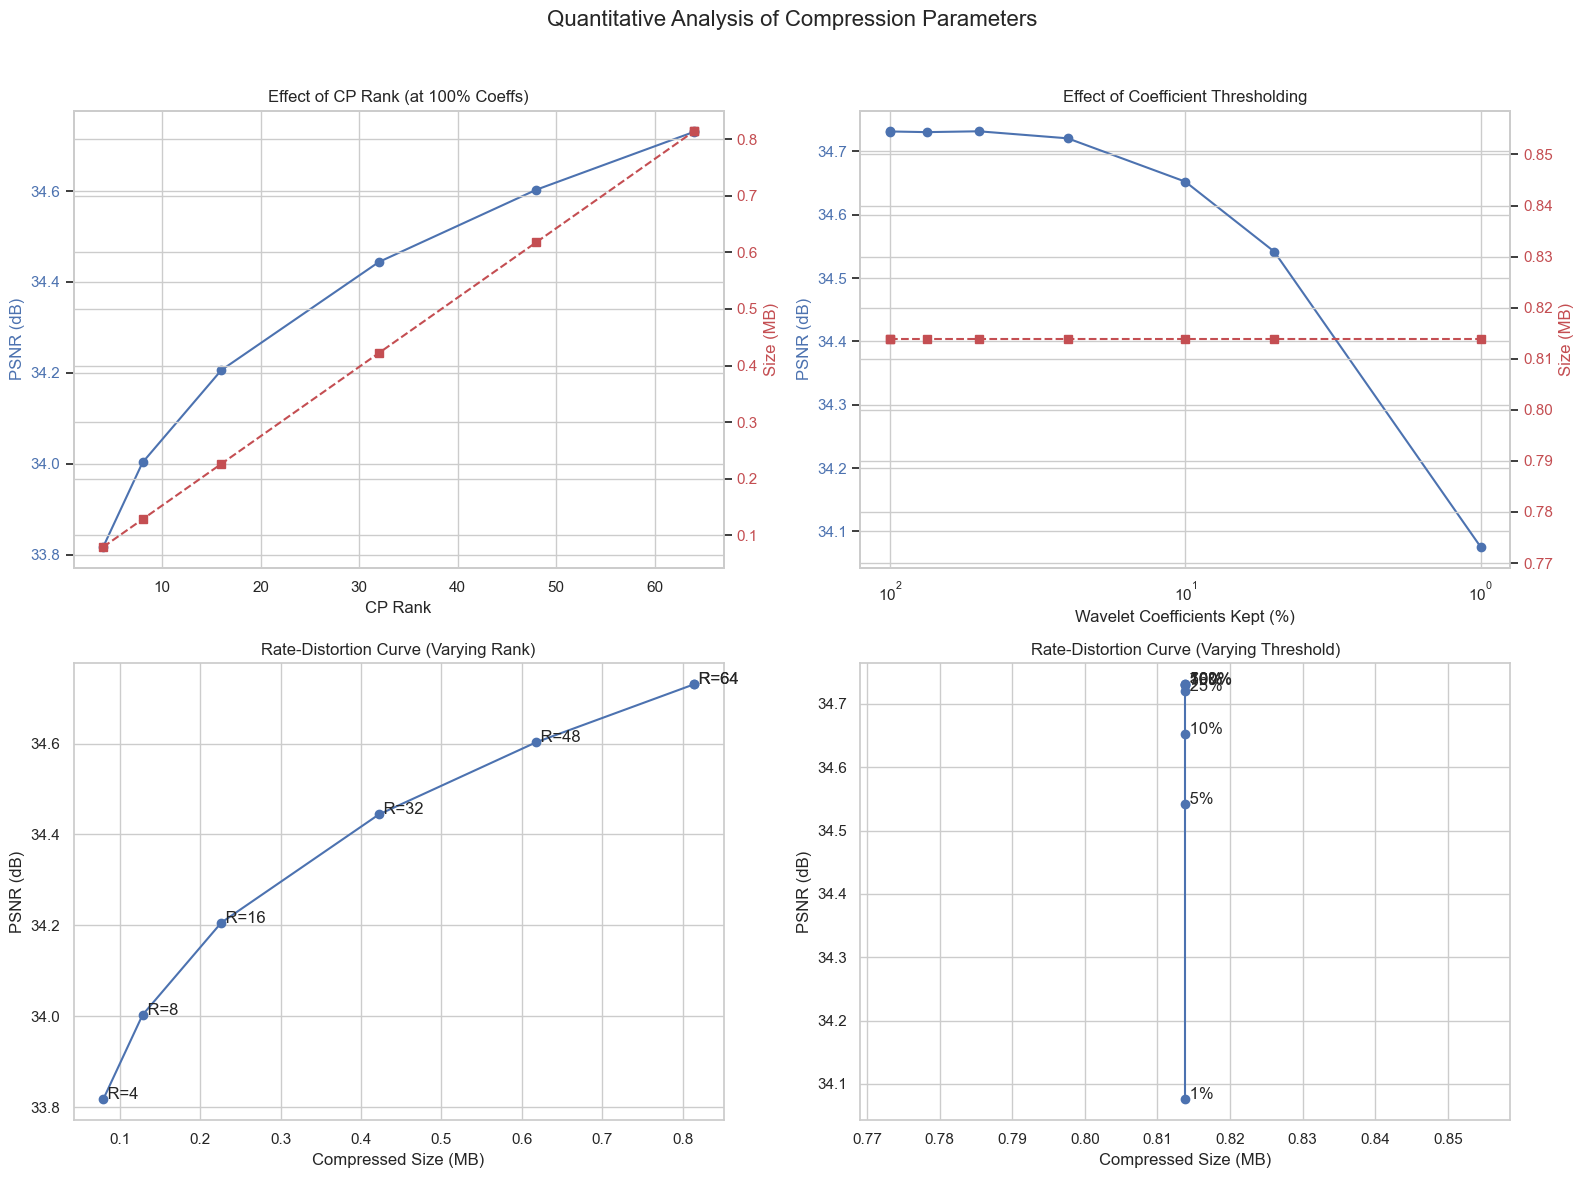

In [16]:
# ===================================================================
#           5. QUANTITATIVE ANALYSIS: VARYING PARAMETERS
# ===================================   ================================
# This cell runs the experiments and plots the results. It requires no changes.

import pandas as pd

all_results = []

# --- Experiment 1: Varying CP Rank ---
ranks_to_test = [4, 8, 16, 32, 48, 64]
logging.info("\n\n===== STARTING EXPERIMENT 1: VARYING RANK =====\n")
for rank in ranks_to_test:
    params = {
        'rank': rank, 'keep_coeffs_percent': 100.0,
        'quant_bits': 12, 'cp_method': 'direct'
    }
    if N_FRAMES <= rank and params["cp_method"] == 'two-stage':
        logging.warning(
            f"Skipping rank {rank} because it's >= N_FRAMES ({N_FRAMES}), incompatible with 'two-stage' method.")
        continue

    results, _ = run_and_analyze_experiment(params)
    all_results.append(results)

# --- Experiment 2: Varying Wavelet Coefficient Threshold ---
coeffs_to_test = [100.0, 75.0, 50.0, 25.0, 10.0, 5.0, 1.0]
logging.info("\n\n===== STARTING EXPERIMENT 2: VARYING THRESHOLD =====\n")
for keep_percent in coeffs_to_test:
    params = {
        'rank': 64, 'keep_coeffs_percent': keep_percent,
        'quant_bits': 12, 'cp_method': 'direct'
    }
    if N_FRAMES <= params['rank'] and params['cp_method'] == 'two-stage':
        params['rank'] = N_FRAMES - 1  # Clamp rank for safety
    results, _ = run_and_analyze_experiment(params)
    all_results.append(results)

# --- Convert results to a DataFrame for easy plotting ---
results_df = pd.DataFrame(all_results)
display(results_df)

# --- Plotting the results ---
if not results_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Quantitative Analysis of Compression Parameters', fontsize=16)

    rank_exp_df = results_df[results_df['keep_coeffs_percent'] == 100.0]
    coeff_exp_df = results_df[results_df['rank'] == results_df['rank'].max()]  # Use max rank tested

    # Plot 1: Rank vs. PSNR & Size
    ax = axes[0, 0]
    if not rank_exp_df.empty:
        ax.plot(rank_exp_df['rank'], rank_exp_df['psnr'], 'o-', label='PSNR (dB)', color='b')
        ax2 = ax.twinx()
        ax2.plot(rank_exp_df['rank'], rank_exp_df['size_mb'], 's--', label='Size (MB)', color='r')
        ax2.set_ylabel('Size (MB)', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
    ax.set_ylabel('PSNR (dB)', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_xlabel('CP Rank')
    ax.set_title('Effect of CP Rank (at 100% Coeffs)')
    ax.grid(True)

    # Plot 2: Coeffs vs. PSNR & Size
    ax = axes[0, 1]
    if not coeff_exp_df.empty:
        ax.plot(coeff_exp_df['keep_coeffs_percent'], coeff_exp_df['psnr'], 'o-', label='PSNR (dB)', color='b')
        ax.set_xscale('log')
        ax.invert_xaxis()
        ax2 = ax.twinx()
        ax2.plot(coeff_exp_df['keep_coeffs_percent'], coeff_exp_df['size_mb'], 's--', label='Size (MB)', color='r')
        ax2.set_ylabel('Size (MB)', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
    ax.set_ylabel('PSNR (dB)', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_xlabel('Wavelet Coefficients Kept (%)')
    ax.set_title('Effect of Coefficient Thresholding')
    ax.grid(True)

    # Plot 3 & 4: Rate-Distortion Curves
    if not rank_exp_df.empty:
        axes[1, 0].plot(rank_exp_df['size_mb'], rank_exp_df['psnr'], 'o-')
        for i, row in rank_exp_df.iterrows():
            axes[1, 0].text(row['size_mb'], row['psnr'], f" R={int(row['rank'])}")
    axes[1, 0].set_xlabel('Compressed Size (MB)')
    axes[1, 0].set_ylabel('PSNR (dB)')
    axes[1, 0].set_title('Rate-Distortion Curve (Varying Rank)')

    if not coeff_exp_df.empty:
        axes[1, 1].plot(coeff_exp_df['size_mb'], coeff_exp_df['psnr'], 'o-')
        for i, row in coeff_exp_df.iterrows():
            axes[1, 1].text(row['size_mb'], row['psnr'], f" {row['keep_coeffs_percent']:.0f}%")
    axes[1, 1].set_xlabel('Compressed Size (MB)')
    axes[1, 1].set_ylabel('PSNR (dB)')
    axes[1, 1].set_title('Rate-Distortion Curve (Varying Threshold)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No results to plot. The experiments may have been skipped or failed.")

2025-08-01 21:55:21,078 - INFO - --- Running experiment with params: {'rank': 16, 'keep_coeffs_percent': 100.0, 'quant_bits': 12, 'cp_method': 'direct'} ---
2025-08-01 21:55:21,079 - INFO - Finding the union of active blocks across all frames...
2025-08-01 21:55:21,153 - INFO - Found 2665 unique blocks across 30 frames.
2025-08-01 21:55:21,154 - INFO - Determining wavelet coefficient length...
C:\Users\zphrfx\Desktop\hdk\VQVDB\.venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
2025-08-01 21:55:21,155 - INFO - Wavelet coefficient length is 512.
2025-08-01 21:55:37,994 - INFO - Finished processing all frames.
2025-08-01 21:55:38,571 - INFO - Quantisation complete. Bits=12. Quantization RMSE (wavelet domain): 0.000369
2025-08-01 21:55:38,572 - INFO - Performing direct CP compression on quantized tensor of shape (30, 2665, 512)...
2025-08-01 21:55:38,845 - INFO - Running Incremental 

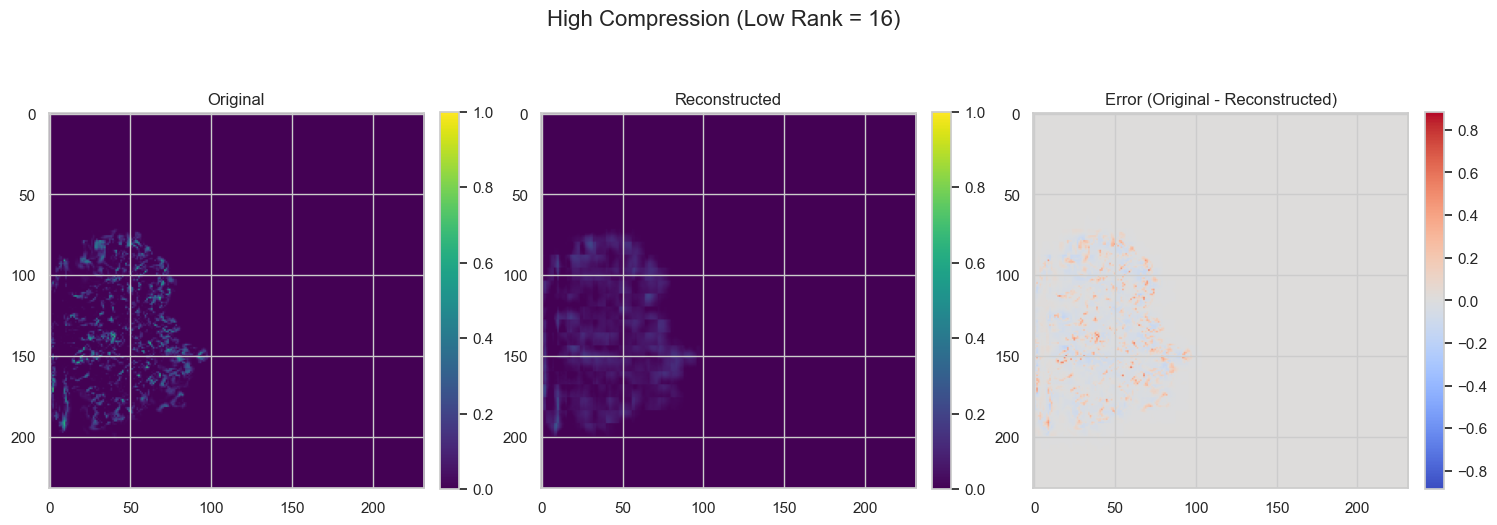

2025-08-01 21:56:39,213 - INFO - --- Running experiment with params: {'rank': 200, 'keep_coeffs_percent': 100.0, 'quant_bits': 12, 'cp_method': 'direct'} ---
2025-08-01 21:56:39,215 - INFO - Finding the union of active blocks across all frames...
2025-08-01 21:56:39,296 - INFO - Found 2665 unique blocks across 30 frames.
2025-08-01 21:56:39,297 - INFO - Determining wavelet coefficient length...
2025-08-01 21:56:39,298 - INFO - Wavelet coefficient length is 512.
2025-08-01 21:56:53,728 - INFO - Finished processing all frames.
2025-08-01 21:56:54,304 - INFO - Quantisation complete. Bits=12. Quantization RMSE (wavelet domain): 0.000369
2025-08-01 21:56:54,305 - INFO - Performing direct CP compression on quantized tensor of shape (30, 2665, 512)...
2025-08-01 21:56:54,587 - INFO - Running Incremental PCA to extract temporal factor...
2025-08-01 21:57:07,581 - INFO - Two-stage CP compression produced rank 29 (including mean).
2025-08-01 21:59:59,593 - INFO - CP approximation RMSE before ref

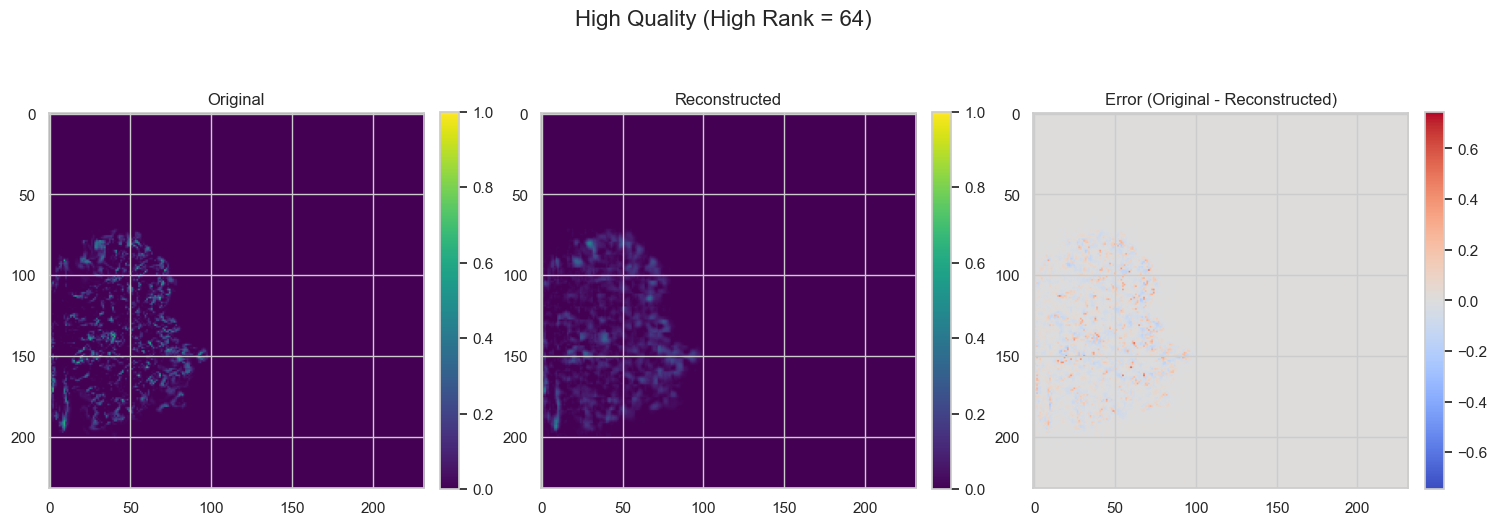

2025-08-01 22:00:31,853 - INFO - --- Running experiment with params: {'rank': 200, 'keep_coeffs_percent': 1.0, 'quant_bits': 12, 'cp_method': 'direct'} ---
2025-08-01 22:00:31,854 - INFO - Finding the union of active blocks across all frames...
2025-08-01 22:00:31,939 - INFO - Found 2665 unique blocks across 30 frames.
2025-08-01 22:00:31,940 - INFO - Determining wavelet coefficient length...
2025-08-01 22:00:31,941 - INFO - Wavelet coefficient length is 512.
2025-08-01 22:00:45,561 - INFO - Finished processing all frames.
2025-08-01 22:00:45,565 - INFO - Applying coefficient thresholding to keep top 1.00%...
2025-08-01 22:00:45,862 - INFO - Calculated threshold: 0.404667. Setting coefficients smaller than this to zero.
2025-08-01 22:00:46,108 - INFO - Thresholding complete. Tensor sparsity is now 0.50% (non-zero elements).
2025-08-01 22:00:46,704 - INFO - Quantisation complete. Bits=12. Quantization RMSE (wavelet domain): 0.000038
2025-08-01 22:00:46,705 - INFO - Performing direct CP 

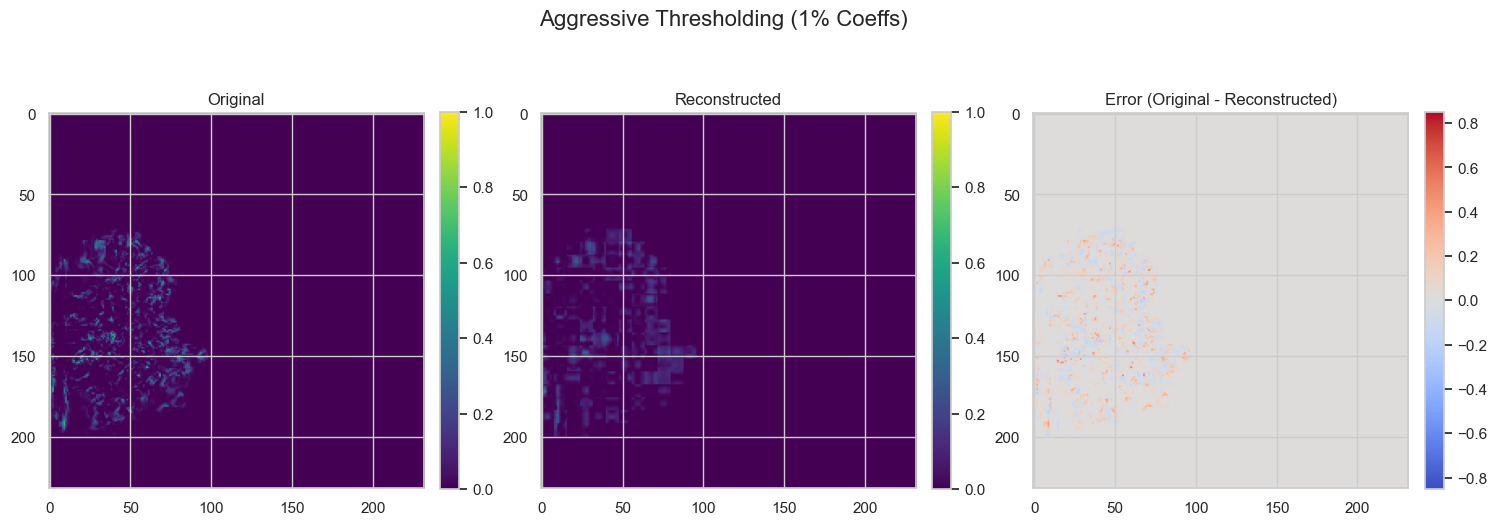

In [19]:
# ===================================================================
#             6. QUALITATIVE ANALYSIS: VISUALIZATION
# ===================================================================
# This cell visualizes the results and also requires no changes.

def plot_comparison(original, reconstructed, slice_idx, title):
    """Plots a side-by-side comparison of a 2D slice."""
    error = original - reconstructed
    vmax = np.max(original) if np.max(original) > 0 else 1.0
    err_max = np.max(np.abs(error)) if np.max(np.abs(error)) > 0 else 1.0

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)

    im = axes[0].imshow(original[slice_idx, :, :], cmap='viridis', vmin=0, vmax=vmax)
    axes[0].set_title('Original')
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    im = axes[1].imshow(reconstructed[slice_idx, :, :], cmap='viridis', vmin=0, vmax=vmax)
    axes[1].set_title('Reconstructed')
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    im = axes[2].imshow(error[slice_idx, :, :], cmap='coolwarm', vmin=-err_max, vmax=err_max)
    axes[2].set_title('Error (Original - Reconstructed)')
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.show()


# --- Select a few interesting cases to visualize ---
cases_to_visualize = [
    {'rank': 16, 'keep_coeffs_percent': 100.0, 'title': 'High Compression (Low Rank = 16)'},
    {'rank': 200, 'keep_coeffs_percent': 100.0, 'title': 'High Quality (High Rank = 64)'},
    {'rank': 200, 'keep_coeffs_percent': 1.0, 'title': 'Aggressive Thresholding (1% Coeffs)'},
]

# Frame and slice to inspect
frame_idx = N_FRAMES - 1  # Last frame
slice_idx = GRID_SIZE // 2
original_frame_to_show = original_frames[frame_idx]

for case in cases_to_visualize:
    params = {
        'rank': case['rank'], 'keep_coeffs_percent': case['keep_coeffs_percent'],
        'quant_bits': 12, 'cp_method': 'direct'
    }
    # Safety check for rank
    if N_FRAMES <= params['rank'] and params['cp_method'] == 'two-stage':
        logging.warning(f"Skipping visualization for rank {params['rank']} as it is incompatible.")
        continue

    _, reconstructed_frames = run_and_analyze_experiment(params)
    reconstructed_frame_to_show = reconstructed_frames[frame_idx]

    plot_comparison(original_frame_to_show, reconstructed_frame_to_show, slice_idx, case['title'])